# Data Content:

**Uber Pickups** in New York City, from 01/01/2015 to 30/06/2015

Weather data from National Centers for Environmental Information.

LocationID to Borough mapping. (by FiveThirtyEight)
NYC public holidays.

The main dataset contained over 10 million observations of 4 variables which aggregated per hour and borough, and then joined with the rest of the datasets producing 29,101 observations across 13 variables. These are:


- **pickup_dt:** Time period of the observations.
- **borough:** NYC's borough.
- **pickups:** Number of pickups for the period.
- **spd:** Wind speed in miles/hour.
- **vsb:** Visibility in Miles to nearest tenth.
- **temp:** temperature in Fahrenheit.
- **dewp:** Dew point in Fahrenheit.
- **slp:** Sea level pressure.
- **pcp01:** 1-hour liquid precipitation.
- **pcp06:** 6-hour liquid precipitation.
- **pcp24:** 24-hour liquid precipitation.
- **sd:** Snow depth in inches.
- **hday:** Being a holiday (Y) or not (N).


# Goal:

In this project, we aim to develop a regression model that can predict the number of pickups in various areas of New York City based on given information. By building an accurate predictive model, we can gain insights into demand patterns and optimize transportation or logistics operations in the city.

### First, let's import the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 



In [3]:
nyc= pd.read_csv('uber_nyc_enriched.csv')

In [4]:
nyc.describe()

,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd
count,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000,29101.000000
mean,490.215903,5.984924,8.818125,47.669042,30.823065,1017.817938,0.003830,0.026129,0.090464,2.529169
std,995.649536,3.699007,2.442897,19.814969,21.283444,7.768796,0.018933,0.093125,0.219402,4.520325
min,0.000000,0.000000,0.000000,2.000000,-16.000000,991.400000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,9.100000,32.000000,14.000000,1012.500000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,6.000000,10.000000,46.000000,30.000000,1018.200000,0.000000,0.000000,0.000000,0.000000
75%,449.000000,8.000000,10.000000,64.500000,50.000000,1022.900000,0.000000,0.000000,0.050000,2.958333
max,7883.000000,21.000000,10.000000,89.000000,73.000000,1043.400000,0.280000,1.240000,2.100000,19.000000


In [5]:
# Identifying null values in the dataframe
nyc.isnull().sum().sort_values(ascending=False)

borough      3043
pickup_dt       0
pickups         0
spd             0
vsb             0
temp            0
dewp            0
slp             0
pcp01           0
pcp06           0
pcp24           0
sd              0
hday            0
dtype: int64

In [6]:
# Identifying duplicate values in the dataframe
nyc.duplicated().sum()

0

In [7]:
nyc.head()

,pickup_dt,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday
0,2015-01-01 01:00:00,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
1,2015-01-01 01:00:00,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
2,2015-01-01 01:00:00,EWR,0,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
3,2015-01-01 01:00:00,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y
4,2015-01-01 01:00:00,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,Y


### Observation

Fortunately, the data we received was already clean and did not require additional cleaning or preprocessing. This allows us to move directly to the feature engineering stage, where we will create and select meaningful features to enhance our regression model's performance.

# Feature Engineering

We have two columns that require transformation to a common scale to ensure our regression model can interpret the data effectively. These columns are:


- **pick_dt:** This column contains datetime information, including the exact date and time of each observation. To make it more useful for our analysis, we will split this column into separate columns representing the day of the week (e.g., Monday, Tuesday...) and the time. This way, we can capture any potential patterns or trends associated with specific days or time ranges.


- **hday:** This is a categorical column with values 'Y' and 'N'. To simplify the data and make it more machine-friendly, we will convert these values to numerical ones. We will replace 'Y' with 1 and 'N' with 0. This binary representation will help our machine learning model handle the data more efficiently, as numerical data is generally easier for algorithms to process and analyze.


In [8]:
nyc=nyc.dropna()
nyc=nyc.reset_index(drop=True)


#Isolating date and time column to uncover potential patterns influenced by specific days and time ranges.
nyc['DayOfWeek'] = pd.to_datetime(nyc['pickup_dt']).dt.day_name()
nyc['Time'] = pd.to_datetime(nyc['pickup_dt']).dt.time
nyc=nyc.drop(columns=['pickup_dt'],errors='ignore')

#Excluding 'EWR' data as it represents a specific region within Queens borough, focusing on main NYC areas.

nyc= nyc[nyc['borough']!='EWR']

#Excluding 'Staten Island' data as it has really small pickup number.
nyc= nyc[nyc['borough']!='Staten Island']

In [9]:
#Changing hday column to numerical values
nyc['hday']=nyc['hday'].apply(lambda x: 1 if x=='Y' else 0)
#Chaning Time column from dt.Time dtype to int
nyc['Time'] = nyc['Time'].apply(str).str[:2].apply(int)


def converter(Day):
    """This function takes a string representing the name of a day of the week and returns its corresponding index.
    The index values range from 0 to 6, representing Monday to Sunday, respectively.

    Parameters:
    day_name (str): The name of the day (e.g., 'Monday', 'Tuesday', etc.).

    Returns:
    int: The index value corresponding to the given day name."""

    week={'Monday':0, 'Tuesday':1,'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
    return week[Day]

nyc['DayOfWeek']= nyc['DayOfWeek'].apply(converter)
nyc=nyc.reset_index(drop=True)


In [10]:
nyc.head(6)

,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday,DayOfWeek,Time
0,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,3,1
1,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,3,1
2,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,3,1
3,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,3,1
4,Bronx,120,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,1,3,2
5,Brooklyn,1229,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,1,3,2


In [11]:
nyc['borough'].unique()

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens'], dtype=object)

## Exploratory Data Analysis (EDA) Step:

Text(0.08, 0.5, 'Y-axis Label')

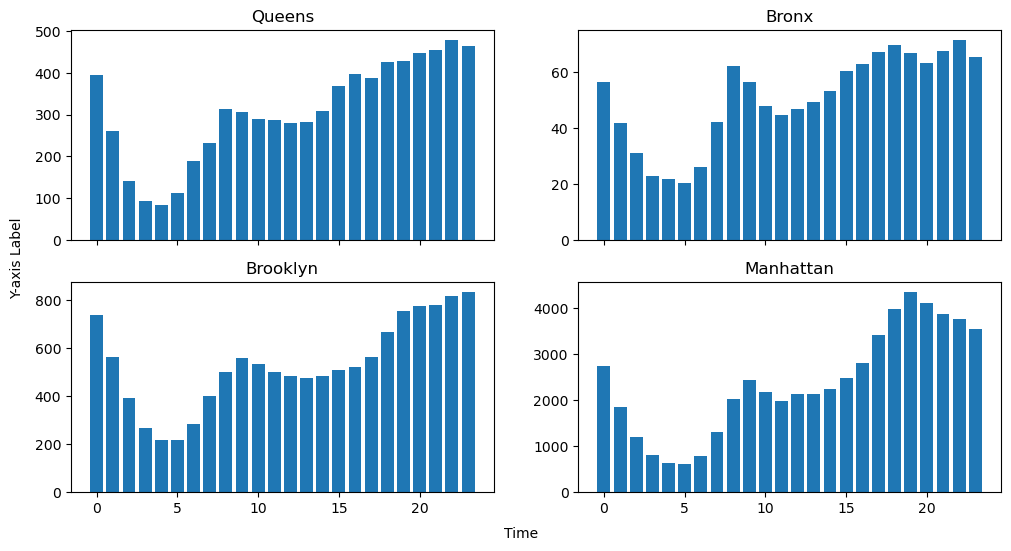

In [12]:
data_queens = nyc[nyc['borough']=='Queens'].groupby('Time')['pickups'].mean().reset_index()
data_bronx = nyc[nyc['borough']=='Bronx'].groupby('Time')['pickups'].mean().reset_index()
data_brooklyn = nyc[nyc['borough']=='Brooklyn'].groupby('Time')['pickups'].mean().reset_index()
data_manhattan = nyc[nyc['borough']=='Manhattan'].groupby('Time')['pickups'].mean().reset_index()


fig, axs= plt.subplots(2, 2,figsize=(12, 6),sharex=True)

axs[0,0].bar(data_queens['Time'],data_queens['pickups'])
axs[0, 0].set_title('Queens')

axs[0,1].bar(data_bronx['Time'],data_bronx['pickups'])
axs[0, 1].set_title('Bronx')

axs[1,0].bar(data_brooklyn['Time'],data_brooklyn['pickups'])
axs[1, 0].set_title('Brooklyn')

axs[1,1].bar(data_manhattan['Time'],data_manhattan['pickups'])
axs[1, 1].set_title('Manhattan')


fig.text(0.5, 0.04, 'Time', ha='center', va='center') 
fig.text(0.08, 0.5, 'Y-axis Label', ha='center', va='center', rotation='vertical') 

### Observation 

As expected, we have observed a pronounced effect of time on the number of pickups. Our findings clearly demonstrate a strong correlation between the time of day and the volume of pickups, highlighting the substantial influence that time exerts on this metric.

# Training Regression Models


I will split the data into separate tables, each representing a specific borough. This approach allows us to train individual models tailored to the unique characteristics of each borough. By doing so, we can predict the number of pickups for each borough independently.


Once the models are trained, we will utilize relevant variables to generate a comprehensive table that presents the predicted pickup numbers for each borough. This table will empower users to make informed decisions based on their specific needs and preferences. Ultimately, our goal is to provide a flexible solution that enables users to identify the borough that best aligns with their transportation or logistics requirements.

### Models testing

In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
from scipy.stats import norm

def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluate a regression model using various performance metrics and return a table of results.
    
    Parameters:
        model (object): The regression model to evaluate.
        X_test (array-like): Test input data.
        y_test (array-like): Test target data.
    
    Returns:
        pandas.DataFrame: Table containing evaluation metrics.
    """

    
    # Make predictions on test data
    y_pred = model.predict(X_test)
    
    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    
    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calculate maximum error
    max_err = max_error(y_test, y_pred)
    
    # Calculate MSE (Mean Squared Error)
    mse = mean_squared_error(y_test, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    

    
    # Create a DataFrame to store results
    results = pd.DataFrame({
        'Metric': ['R² (Coefficient of Determination)', 'RMSE (Root Mean Squared Error)',
                   'Max Error', 'MSE (Mean Squared Error)', 'MAPE (Mean Absolute Percentage Error)'],
        'Value': [r2, rmse, max_err, mse, mape]
    })
    
    return results

In [14]:
from sklearn.model_selection import train_test_split

#A thorough analysis revealed that the variables 'spd' and 'vsb' have a negligible impact on predicting pickup numbers.
X= nyc[nyc['borough']=='Manhattan'].drop(columns=['pickups','borough','spd', 'vsb'])

y = nyc[nyc['borough']=='Manhattan']['pickups']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [15]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train, y_train)

evaluate_regression_model(rfr, X_test, y_test)

,Metric,Value
0,R² (Coefficient of Determination),9.101489e-01
1,RMSE (Root Mean Squared Error),4.312703e+02
2,Max Error,2.713840e+03
3,MSE (Mean Squared Error),1.859940e+05
4,MAPE (Mean Absolute Percentage Error),inf


In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train, y_train)

evaluate_regression_model(lin_reg, X_test, y_test)

,Metric,Value
0,R² (Coefficient of Determination),4.110340e-01
1,RMSE (Root Mean Squared Error),1.104162e+03
2,Max Error,4.549995e+03
3,MSE (Mean Squared Error),1.219175e+06
4,MAPE (Mean Absolute Percentage Error),inf


In [17]:
from sklearn.tree import DecisionTreeRegressor

dstree = DecisionTreeRegressor().fit(X_train, y_train)

evaluate_regression_model(dstree, X_test, y_test)


,Metric,Value
0,R² (Coefficient of Determination),8.050951e-01
1,RMSE (Root Mean Squared Error),6.351836e+02
2,Max Error,5.063000e+03
3,MSE (Mean Squared Error),4.034582e+05
4,MAPE (Mean Absolute Percentage Error),inf


In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor().fit(X_train, y_train)

evaluate_regression_model(gbr, X_test, y_test)


,Metric,Value
0,R² (Coefficient of Determination),8.434292e-01
1,RMSE (Root Mean Squared Error),5.693028e+02
2,Max Error,2.979250e+03
3,MSE (Mean Squared Error),3.241056e+05
4,MAPE (Mean Absolute Percentage Error),inf


## Conclusion

Upon evaluating various regression models, it is evident that the Random Forest Regressor stands out with the best performance. As a result, we have decided to utilize this model consistently across all the remaining datasets. By employing the Random Forest Regressor, we can leverage its ability to capture complex relationships and make accurate predictions for each borough's pickup patterns.

#### Training an Random Foresst Regressor with Bronx data

In [19]:
from sklearn.model_selection import train_test_split

X= nyc[nyc['borough']=='Bronx'].drop(columns=['pickups','borough','spd', 'vsb'])

y = nyc[nyc['borough']=='Bronx']['pickups']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
from sklearn.ensemble import RandomForestRegressor

RFR_Bronx = RandomForestRegressor(random_state=42)

RFR_Bronx.fit(X_train, y_train)


RFR_Bronx.score(X_test, y_test)

0.8412973751354831

### Training with Brooklyn data

In [21]:
from sklearn.model_selection import train_test_split

X= nyc[nyc['borough']=='Brooklyn'].drop(columns=['pickups','borough','spd', 'vsb'])

y = nyc[nyc['borough']=='Brooklyn']['pickups']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [22]:
from sklearn.ensemble import RandomForestRegressor

RFR_Brooklyn = RandomForestRegressor(random_state=42)

RFR_Brooklyn.fit(X_train, y_train)

RFR_Brooklyn.score(X_test, y_test)

0.9403000671821027

### Training with Staten Island data

In [23]:
from sklearn.model_selection import train_test_split

X= nyc[nyc['borough']=='Manhattan'].drop(columns=['pickups','borough','spd', 'vsb'])

y = nyc[nyc['borough']=='Manhattan']['pickups']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [24]:
from sklearn.ensemble import RandomForestRegressor

RFR_Manhattan = RandomForestRegressor(random_state=42)

RFR_Manhattan.fit(X_train, y_train)

RFR_Manhattan.score(X_test, y_test)

0.9101489082711629

### Training with Queens data

In [25]:
from sklearn.model_selection import train_test_split

X= nyc[nyc['borough']=='Queens'].drop(columns=['pickups','borough','spd', 'vsb'])

y = nyc[nyc['borough']=='Queens']['pickups']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [26]:
from sklearn.ensemble import RandomForestRegressor

RFR_Queens = RandomForestRegressor(random_state=42)

RFR_Queens.fit(X_train, y_train)

RFR_Queens.score(X_test, y_test)

0.9022573549042608

### Prediction

In [27]:
nyc.head()

,borough,pickups,spd,vsb,temp,dewp,slp,pcp01,pcp06,pcp24,sd,hday,DayOfWeek,Time
0,Bronx,152,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,3,1
1,Brooklyn,1519,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,3,1
2,Manhattan,5258,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,3,1
3,Queens,405,5.0,10.0,30.0,7.0,1023.5,0.0,0.0,0.0,0.0,1,3,1
4,Bronx,120,3.0,10.0,30.0,6.0,1023.0,0.0,0.0,0.0,0.0,1,3,2


In [28]:
def Predict_pickups(temp, dewp, slp, pcp01, pcp06, pcp24, sd, isholiday, Day, time):
    week={'Monday':0, 'Tuesday':1,'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
    holiday={'Yes':1, 'No':0}
    hday=holiday[isholiday]
    DayOfWeek=week[Day]
    data_dict = {
        'temp': [temp],
        'dewp': [dewp],
        'slp': [slp],
        'pcp01': [pcp01],
        'pcp06': [pcp06],
        'pcp24': [pcp24],
        'sd': [sd],
        'hday': [hday],
        'DayOfWeek': [DayOfWeek],
        'Time': [time]
    }

    # Create a DataFrame from the dictionary
    data_df = pd.DataFrame(data_dict)

    # Make predictions for all boroughs using the DataFrame
    predictions = {
        'Manhattan': RFR_Manhattan.predict(data_df),
        'Bronx': RFR_Bronx.predict(data_df),
        'Brooklyn': RFR_Brooklyn.predict(data_df),
        'Queens': RFR_Queens.predict(data_df)
    }

    # Print the predicted pickups for each borough
    for borough, predicted_pickups in predictions.items():
        print(f"Predicted pickups in {borough}: {predicted_pickups[0]}")

In [29]:
Predict_pickups(60, 6, 1024, 0, 0.1, .21, 0, 'Yes', 'Tuesday', '8')

Predicted pickups in Manhattan: 1041.55
Predicted pickups in Bronx: 42.77
Predicted pickups in Brooklyn: 352.88
Predicted pickups in Queens: 319.45


### we can make it interactive

In [32]:
from ipywidgets import interact_manual


interact_manual(Predict_pickups,
                temp=(0,110,.1),
                dewp=(15,70,.1),
                slp=(29,31,0.01),
                pcp01=(0,2.5,.002),
                pcp06=(0,2.5,0.002),
                pcp24=(0,2.5,0.002),
                sd=(0,200,1),
                isholiday=['Yes','No'],
                Day= ['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                time= (0,23,1))


interactive(children=(FloatSlider(value=55.0, description='temp', max=110.0), FloatSlider(value=42.0, descript…

<function __main__.Predict_pickups(temp, dewp, slp, pcp01, pcp06, pcp24, sd, isholiday, Day, time)>